In [ ]:
#그래프 한글폰트 설정
#!sudo apt-get install -y fonts-nanum 
#!sudo fc-cache -fv 
#!rm ~/.cache/matplotlib -rf
import matplotlib.pyplot as plt 
plt.rc('font', family='NanumBarunGothic')

In [ ]:
import pandas as pd

df=pd.read_csv("https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/datasets/vgames2.csv")
df=df.drop('Unnamed: 0',axis=1)
print(df.shape)

print(df.isna().sum())

#Sales의 값 전처리 str -> float (단위: 백만)
Sales_num=[[],[],[],[]]
Sales_name=['NA_Sales','EU_Sales','JP_Sales','Other_Sales']
for i in range(4):
  for k in range(df.shape[0]):
    try:
      Sales_num[i].append(float(df[Sales_name[i]][k]))
    except:
      num=float(df[Sales_name[i]][k][:-1])
      unit=df[Sales_name[i]][k][-1]
      if unit == 'K':
        Sales_num[i].append(num/1000)
      elif unit == 'M':
        Sales_num[i].append(num)
  df[Sales_name[i]]=Sales_num[i]

#Year의 값 전처리 4자리의 년도수로 통일(N/A: -1)
df['Year']=df['Year'].fillna(-1)
Years=[]
for i in range(df.shape[0]):
  if df['Year'][i] == -1:
    Years.append(-1)
  elif df['Year'][i] < 50:
    Years.append(int(df['Year'][i])+2000)
  elif df['Year'][i] <100:
    Years.append(int(df['Year'][i])+1900)
  else:
    Years.append(int(df['Year'][i]))
df['Year']=Years

#게임별 Sales 총합 열 생성 
df['total_Sales']=df.loc[:,'NA_Sales':'Other_Sales'].sum(axis=1)
df.head(16)


(16598, 9)
Name             0
Platform         0
Year           271
Genre           50
Publisher       58
NA_Sales         0
EU_Sales         0
JP_Sales         0
Other_Sales      0
dtype: int64


,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,total_Sales
0,Candace Kane's Candy Factory,DS,2008,Action,Destineer,0.04,0.00,0.00,0.00,0.04
1,The Munchables,Wii,2009,Action,Namco Bandai Games,0.17,0.00,0.00,0.01,0.18
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010,Adventure,Alchemist,0.00,0.00,0.02,0.00,0.02
3,Deal or No Deal: Special Edition,DS,2010,Misc,Zoo Games,0.04,0.00,0.00,0.00,0.04
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010,Platform,D3Publisher,0.12,0.09,0.00,0.04,0.25
5,Power Pro Kun Pocket 8,DS,2005,Sports,Konami Digital Entertainment,0.00,0.00,0.14,0.00,0.14
6,JASF: Jane's Advanced Strike Fighters,PC,2011,Simulation,Deep Silver,0.02,0.01,0.00,0.00,0.03
7,Samurai Warriors: State of War,PSP,2005,Action,Tecmo Koei,0.07,0.00,0.11,0.01,0.19
8,Imabikisou,PS3,2007,Adventure,Sega,0.00,0.00,0.04,0.00,0.04
9,The Penguins of Madagascar: Dr. Blowhole Retur...,PS3,2011,Action,THQ,0.04,0.03,0.00,0.01,0.08


anova test:
p_value(3featur): 0.0034356319791749804

two sample Chi-squared test:
p_value(NA | EU): 0.005433019172813195
p_value(NA | JP): 0.06344850635615636
p_value(EU | JP): 0.08176541624472157


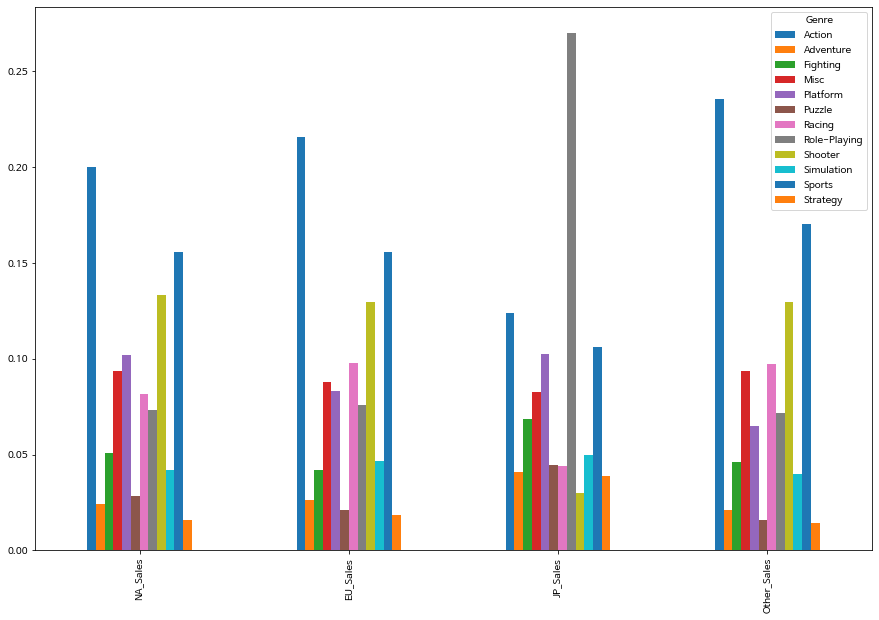

In [ ]:
from scipy import stats
import matplotlib.pyplot as plt

#장르별 선호도차이 비교를 위한 전처리(각 나라의 장르별 누적 구매 비율 테이블 생성)
df_Genre=pd.concat([df[['Genre']],df[['NA_Sales','EU_Sales','JP_Sales','Other_Sales']]],axis=1)
df_Genre=df_Genre.groupby('Genre').sum()
df_Genre1=(df_Genre/df_Genre.sum()).transpose()

#지역별 장르별 구매 빈도의 유사도 확인(anova,chi2)
t_anova,p_anova=stats.f_oneway(df_Genre['NA_Sales'],df_Genre['EU_Sales'],df_Genre['JP_Sales'])
NA_cut=pd.cut(df_Genre1.transpose()['NA_Sales'],5).astype('category')
EU_cut=pd.cut(df_Genre1.transpose()['EU_Sales'],5).astype('category')
JP_cut=pd.cut(df_Genre1.transpose()['JP_Sales'],5).astype('category')
data1=pd.crosstab(NA_cut,EU_cut)
data2=pd.crosstab(NA_cut,JP_cut)
data3=pd.crosstab(EU_cut,JP_cut)
_,p_data1,_,_=stats.chi2_contingency(data1)
_,p_data2,_,_=stats.chi2_contingency(data2)
_,p_data3,_,_=stats.chi2_contingency(data3)
print("anova test:")
print("p_value(3featur):",p_anova)
print("\ntwo sample Chi-squared test:")
print("p_value(NA | EU):",p_data1)
print("p_value(NA | JP):",p_data2)
print("p_value(EU | JP):",p_data3)

df_Genre1.plot(kind='bar',figsize=(15,10))

anova 테스트 결과 지역(나라)별 선호하는 게임 장르가 같다고 할수 없다.

하지만 미국과 유럽은 지역(나라)별 선호하는 게임의 장르가 유의미한 수준 까지 동일하다고 할수 있다.

이를 바탕으로 지역(나라)에 따른 장르별 소비성향이 같다고 볼수 없지만 미국과 유럽의 게임 소비자의 장르별 소비성향이 유사하다고 판단할수 있다.

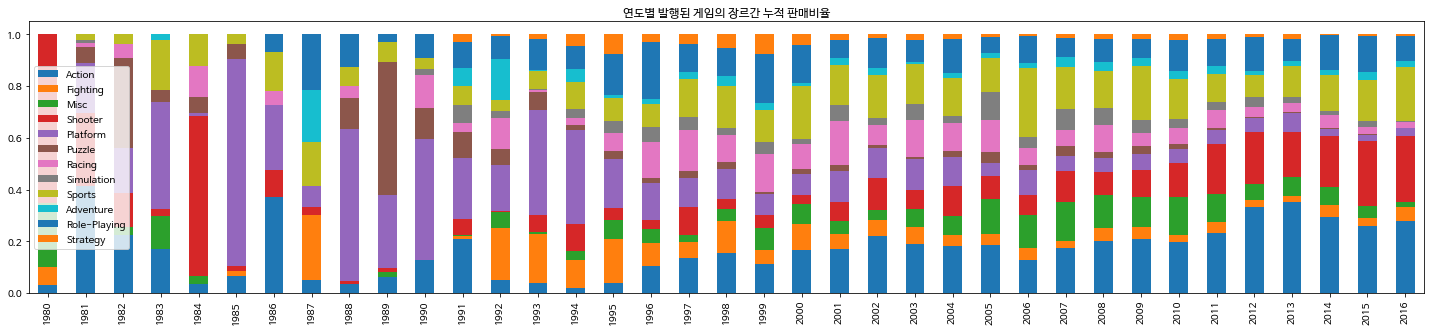

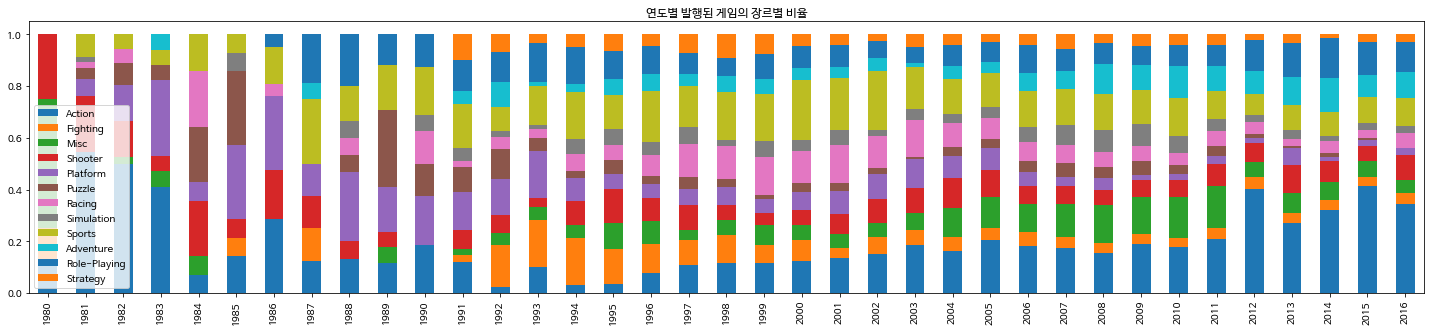

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns

#연도별 장르 누적판매수 df(df_GbyY1) 생성 -> 백분률화 그래프표 생성(df_GbyY2)
Years_uni=df['Year'][df['Year']!=-1].unique()
df_GbyY=df[['Year','Genre','total_Sales']].groupby(['Year','Genre']).sum().drop(-1)
Years_uni=np.sort(Years_uni)
df_GbyY1=df_GbyY.loc[1980].transpose()

for i in Years_uni[1:]:
  df_GbyY1=pd.concat([df_GbyY1,df_GbyY.loc[i].transpose()])
df_GbyY1.index=Years_uni
df_GbyY1=df_GbyY1.fillna(0)

df_GbyY2=df_GbyY1.transpose().copy()
for i in df_GbyY2:
  df_GbyY2[i]=df_GbyY2[i]/df_GbyY2[i].sum()
df_GbyY2=df_GbyY2.transpose()
df_GbyY2.iloc[:-2].plot(kind='bar',stacked=True,figsize=(25,5),title='연도별 발행된 게임의 장르간 누적 판매비율')

#연도별 장르별 게임 발행 갯수 df(df_GbyYG) 생성 -> 백분률화 그래프표 생성(df_GbyYG1)
df_GbyYG=df.groupby(['Year','Genre']).count().drop(-1)[['Name']]
df_GbyYG1=(df_GbyYG.loc[1980]/df_GbyYG.loc[1980].sum()).transpose()

for i in Years_uni[1:]:
  set1=(df_GbyYG.loc[i]/df_GbyYG.loc[i].sum()).transpose()
  df_GbyYG1=pd.concat([df_GbyYG1,set1])

df_GbyYG1=df_GbyYG1.fillna(0)
df_GbyYG1.index=Years_uni
df_GbyYG1.iloc[:-2].plot(kind='bar',stacked=True,figsize=(25,5),title='연도별 발행된 게임의 장르별 비율')



In [ ]:
#연도별 누적판매 비율과 연도별 장르간 게임 발행 비율에 대한 연관성 검증
pca=PCA(2)
pca=pca.fit(df_GbyY2)
pca=pca.transform(df_GbyY2)

pca2=PCA(2)
pca2=pca2.fit(df_GbyYG1)
pca2=pca2.transform(df_GbyYG1)

pca=pd.cut(pca[:,0],10).astype('category')
pca2=pd.cut(pca2[:,0],10).astype('category')
pca_cross=pd.crosstab(pca,pca2)
df_GbyYG1_chi2=stats.chi2_contingency(pca_cross)
print("two sample Chi-squared test:")
print("p_value(연도별 발행된 게임의 장르간 누적 판매비율 | 연도별 발행된 게임의 장르별 비율):",df_GbyYG1_chi2[1])

two sample Chi-squared test:
p_value(연도별 발행된 게임의 장르간 누적 판매비율 | 연도별 발행된 게임의 장르별 비율): 0.37861345474896396


연도별 누적판매 비율은 장르간 게임발행 비율과 연관이 없다를 증명하기 위해 검증을 진행한 결과 p_value가 유의미한 값 이상을 가지므로 두 비율간 빈도에 대한 연관성이 없다고 할수 있습니다.

즉 해당연도에 어떠한 한 장르에 대한 게임 발행 비율이 높다고 하여 해당연도에 발행된 장르들중 가장 많은 누적 판매량을 기록하지않는다고 할수 있습니다.

그러므로 해당 연도의 누적판매 비율은 게임발행빈도와 상관없이 수요자들이 해당 연도에 가장 흥미를 나타낸 장르를 나타낸다고 할수 있는 트렌트의 변화를 반영한다고 판단할수 있습니다.

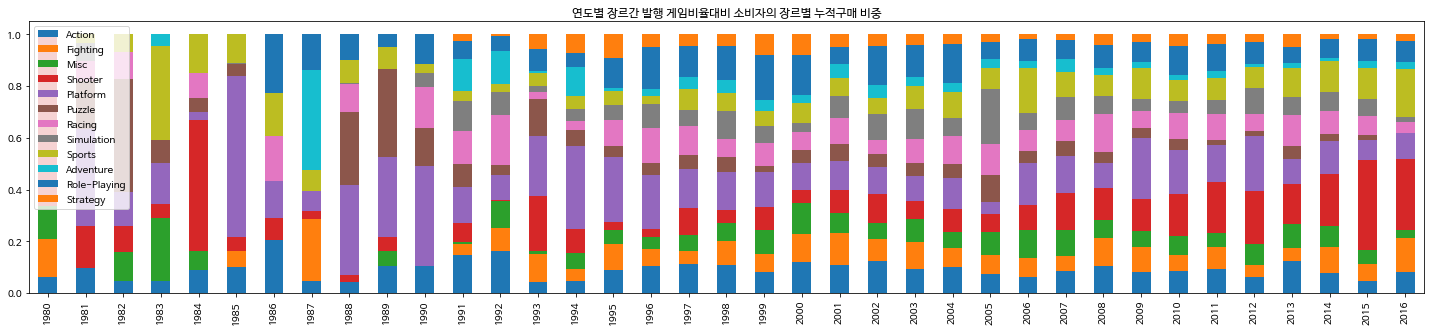

In [ ]:
df_trend=(df_GbyY2/df_GbyYG1).fillna(0)

#df_trend[:-2].plot(kind='bar',stacked=True,figsize=(25,5))
for i in df_trend.index:
  df_trend.loc[i]=df_trend.loc[i]/df_trend.loc[i].sum()
df_trend[:-2].plot(kind='bar',stacked=True,figsize=(25,5),title='연도별 장르간 발행 게임비율대비 소비자의 장르별 누적구매 비중')

연도별 장르간 발행 게임비율로 소비자의 장르별 구매 비중을 나눈 값을 비교한 그래프입니다.

해당 연도에서 가장 많은 비중을 차지하고 있는 장르가 해당연도에 발매된 게임수 대비 다른장르보다 더많은 구매가 이루어졌다고 볼수 있으며,

 이는 연도별 행당 장르에 대한 소비자들의 성향을 나타낸다고 할수 있습니다. 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.


total_Sales
Genre        Name                                                
Shooter      Call of Duty: Black Ops                        31.04
             Call of Duty: Modern Warfare 3                 30.84
             Call of Duty: Black Ops II                     29.73
             Duck Hunt                                      28.31
             Call of Duty: Ghosts                           27.37
             Call of Duty: Black Ops 3                      25.30
             Call of Duty: Modern Warfare 2                 25.10
             Call of Duty: Advanced Warfare                 21.89
             Call of Duty 4: Modern Warfare                 18.26
             Battlefield 3                                  17.37
             Call of Duty: World at War                     15.88
Sports       Wii Sports                                     82.74
             Wii Sports Resort                              33.00
             Wii Fit                                        22.72
             Wii Fit Plus                                   22.00
             FIFA 15                                        19.02
             FIFA 14                                        17.16
             FIFA 16                                        16.43
Platform     Super Mario Bros.                              45.31
             New Super Mario Bros.                          30.01
             New Super Mario Bros. Wii                      28.61
             Super Mario World                              26.09
             Super Mario Bros. 3                            22.49
             Super Mario 64                                 22.32
             Super Mario Land                               18.14
Role-Playing Pokemon Red/Pokemon Blue                       31.38
             Pokemon Gold/Pokemon Silver                    23.09
             The Elder Scrolls V: Skyrim                    19.28
             Pokemon Diamond/Pokemon Pearl                  18.35
             Pokemon Ruby/Pokemon Sapphire                  15.84
             Pokemon Black/Pokemon White                    15.32
             Pokémon Yellow: Special Pikachu Edition        14.64

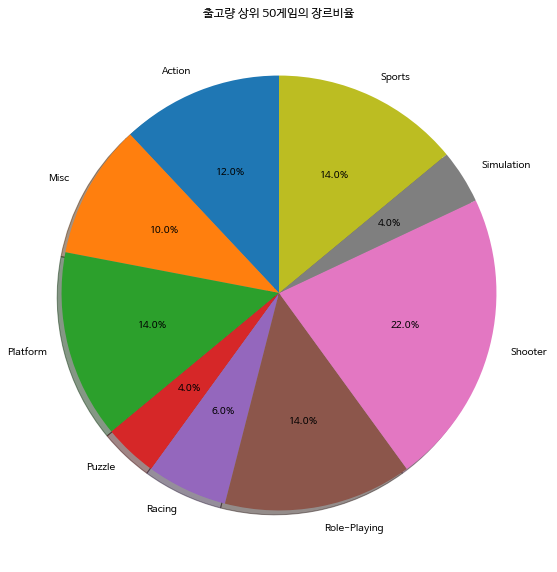

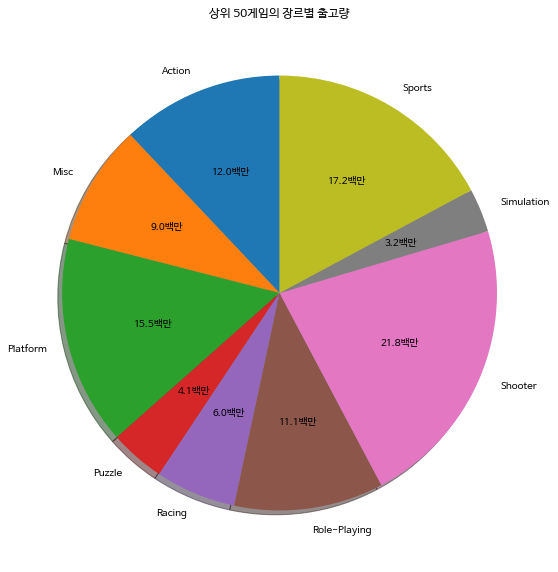

In [ ]:
#중복 타이틀 합친 후 total_Sales 기준 정렬
df['total_Sales']=df.loc[:,'NA_Sales':'Other_Sales'].sum(axis=1)
df_srt_NG=df[['Name','Genre','total_Sales']].groupby(['Name','Genre']).sum().sort_values('total_Sales',ascending=False)
srt_Genre_list=[]
srt_Name_list=[]
for i in df_srt_NG.index:
  srt_Genre_list.append(i[1])
  srt_Name_list.append(i[0])
df_srt_NG['Genre']=srt_Genre_list
df_srt_NG['Name']=srt_Name_list
df_srt_NG.index=range(df_srt_NG.index.shape[0])
df_srt_NG_50=df_srt_NG.head(50)

#상위 50게임의 장르별 비중 그래프
df_srt_NG_50_1=df_srt_NG_50.groupby('Genre').count()[['Name']]
df_srt_NG_50_1=df_srt_NG_50_1/df_srt_NG_50_1.sum()
plt.figure(figsize=(10,10))
plt.title('출고량 상위 50게임의 장르비율')
plt.pie(df_srt_NG_50_1,labels=df_srt_NG_50_1.index,autopct='%1.1f%%',shadow=True,startangle=90)

#상위 50게임의 장르별 누적판매 그래프
df_srt_NG_50_2=df_srt_NG_50.groupby('Genre').sum()
plt.figure(figsize=(10,10))
plt.title('상위 50게임의 장르별 출고량')
plt.pie(df_srt_NG_50_2,labels=df_srt_NG_50_2.index,autopct='%1.1f백만',shadow=True,startangle=90)

#상위 50게임의 장르별 판매순서로 정렬한 표생성
df_srt_NG_50=df_srt_NG_50.groupby(['Genre','Name']).sum().loc[['Shooter','Sports','Platform','Role-Playing']]
df_srt_NG_50_list=df_srt_NG_50.loc[['Shooter']].sort_values('total_Sales',ascending=False)
for i in ['Sports','Platform','Role-Playing']:
  df_srt_NG_50_list=pd.concat([df_srt_NG_50_list,df_srt_NG_50.loc[[i]].sort_values('total_Sales',ascending=False)])
df_srt_NG_50_list

출고량 상위 50개의 게임에 대해 각 장르별 비중과 리스트를 분석한 결과 많은 출고량을 기록한 게임들의 지속적인 시리즈 발매가 이루어진것과 함께 두꺼운 팬층이 형성되었을 것이라고 추측됩니다.

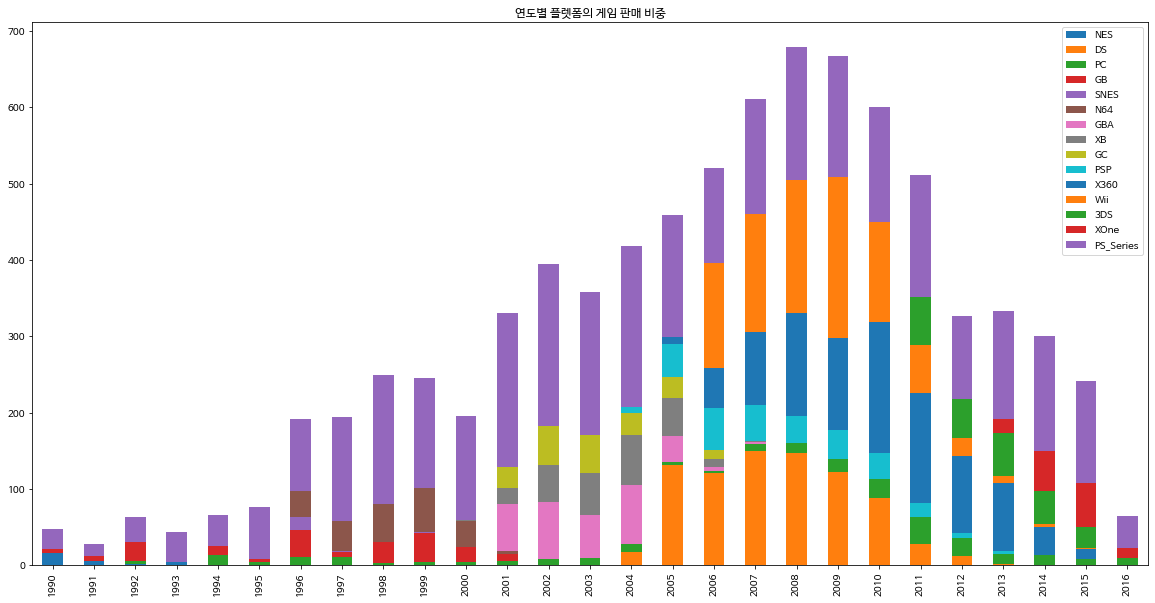

In [ ]:
#연도별 플랫폼간 판매량 df 생성(df_PbyY1)
df_PbyY=df.groupby(['Year','Platform']).sum().drop(-1)[['total_Sales']]
df_PbyY1=df_PbyY.loc[1980].transpose()
for i in Years_uni[1:]:
  df_PbyY1=pd.concat([df_PbyY1,df_PbyY.loc[i].transpose()])

#PS시리즈 판매량 통일
df_PbyY1.index=Years_uni
df_PbyY1['PS_Series']=df_PbyY1[['PS','PS2','PS3','PS4']].sum(axis=1)
df_PbyY1=df_PbyY1.drop(['PS','PS2','PS3','PS4'],axis=1)
df_PbyY1=df_PbyY1.fillna(0)

#총 누적 판매량이 100만장 미만인 플랫폼 제거후 그래프화
for i in df_PbyY1:
  if df_PbyY1[i].sum()<100:
    df_PbyY1=df_PbyY1.drop(i,axis=1)
df_PbyY1.iloc[10:-2].plot(kind='bar',stacked=True,figsize=(20,10),title='연도별 플렛폼의 게임 판매 비중')

게임을 개발하고 발매할 경우 플렛폼은 PS와 PC, Xone 플렛폼 순으로 발매하는 것이 소비자 접근성이 가장 좋을 것으로 판단 됩니다.